# Coding Discussion 6

## Anandi Gupta

# Dependencies

In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline


# Data

DC Housing Price data. 

In [2]:
# Data on Housing Prices in DC
train = pd.read_csv("/Users/anandigupta/Desktop/coding_discussions_ppol564_fall2021/06_coding_discussion/train_data.csv")
train.shape

(43590, 39)

In [3]:
test = pd.read_csv("/Users/anandigupta/Desktop/coding_discussions_ppol564_fall2021/06_coding_discussion/test_data.csv")
test.shape

(14531, 39)

In [4]:
# Available features
list(train)

['OBJECTID',
 'SSL',
 'BATHRM',
 'HF_BATHRM',
 'HEAT',
 'HEAT_D',
 'AC',
 'NUM_UNITS',
 'ROOMS',
 'BEDRM',
 'AYB',
 'YR_RMDL',
 'EYB',
 'STORIES',
 'SALEDATE',
 'QUALIFIED',
 'SALE_NUM',
 'GBA',
 'BLDG_NUM',
 'STYLE',
 'STYLE_D',
 'STRUCT',
 'STRUCT_D',
 'GRADE',
 'GRADE_D',
 'CNDTN',
 'CNDTN_D',
 'EXTWALL',
 'EXTWALL_D',
 'ROOF',
 'ROOF_D',
 'INTWALL',
 'INTWALL_D',
 'KITCHENS',
 'FIREPLACES',
 'USECODE',
 'LANDAREA',
 'GIS_LAST_MOD_DTTM',
 'LN_PRICE']

Look at **missingness** in the data: Issue we're missing information on the outcome `PRICE`

<AxesSubplot:>

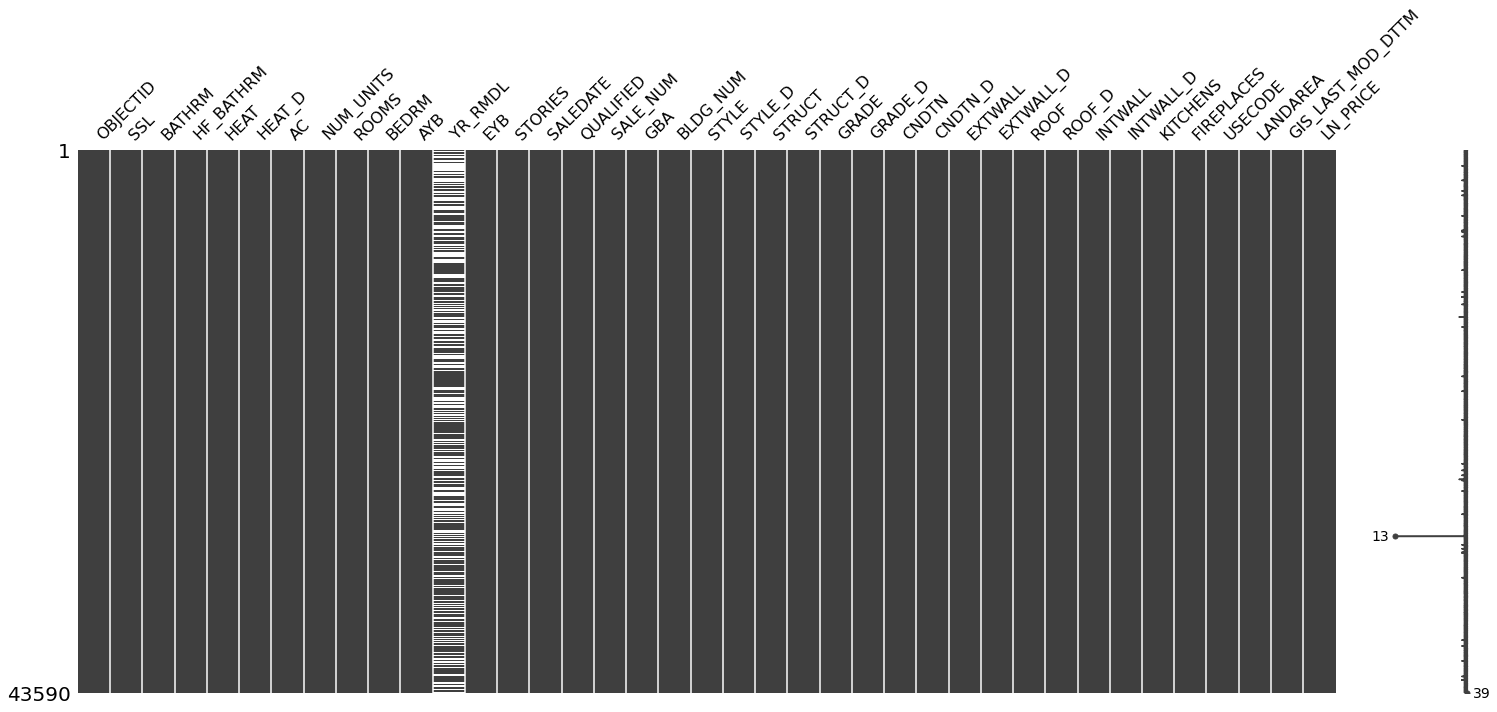

In [5]:
miss.matrix(train)

Let's do the following:
- Only retain data values where the outcome is measured.
- Only retain observations where there is a selling price (i.e. when `PRICE == 0`, the house hasn't been sold. We're interested in what predict the sell price _given that it was sold_.)

In [6]:
#Pre-process the data

# Drop all observations where the outcome is missing 
train = train[~train.LN_PRICE.isna()]

# Only houses that are sold
train = train[train.LN_PRICE > 0]
train = train[train.LANDAREA > 0]

#Remove observations where our predictors have NAs
train = train.dropna(subset = ['BATHRM','BEDRM','CNDTN','FIREPLACES', 'LANDAREA'])

# Drop all observations where the outcome is missing 
test = test[~test.LN_PRICE.isna()]

# Only houses that are sold
test = test[test.LN_PRICE > 0]

#Drop observations with land area = 0 as we log this variable
test = test[test.LANDAREA > 0]

#Remove observations where our predictors have NAs
test = test.dropna(subset = ['BATHRM','BEDRM','CNDTN','FIREPLACES', 'LANDAREA'])


Set up data in the **SKLEARN framework** (i.e. outcome separated from the predictors).

In [7]:
#Outcome variable - log prices
train_Y = train['LN_PRICE'] 
test_Y = test['LN_PRICE']

#subset to predictors and log landarea
train_X = train[['BATHRM','BEDRM','CNDTN','FIREPLACES', 'LANDAREA']] 
train_X['LANDAREA'] = np.log(train_X['LANDAREA'])
test_X = test[['BATHRM', 'BEDRM', 'CNDTN','FIREPLACES', 'LANDAREA']] 
test_X['LANDAREA'] = np.log(test_X['LANDAREA'])

## Explore the training data 

In [8]:
#look at training data
train_X.head()

,BATHRM,BEDRM,CNDTN,FIREPLACES,LANDAREA
0,3.0,4.0,5.0,0.0,7.711549
1,2.0,3.0,5.0,1.0,8.255828
2,2.0,4.0,3.0,1.0,8.970305
3,1.0,3.0,3.0,0.0,7.915348
4,2.0,4.0,3.0,0.0,7.648263


In [9]:
#look at training data
train_Y.head()

0    13.591116
1    12.730801
2    13.651814
3    12.860999
4    14.100690
Name: LN_PRICE, dtype: float64

In [10]:
# Look at the training data
train_X.shape


(43581, 5)

Visualize the data to check how it is distributed

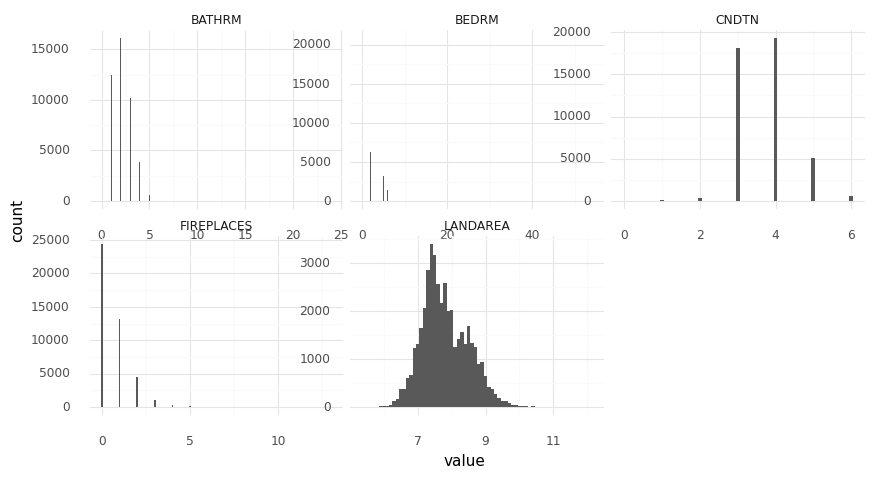

<ggplot: (8762564033732)>

In [11]:
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram(binwidth = 0.1) +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,5)) 
) 

Insights:
- Scale will be an issue. So we need to pre-process


Look at the outcome `LN_PRICE` and see if there are any red flags. 

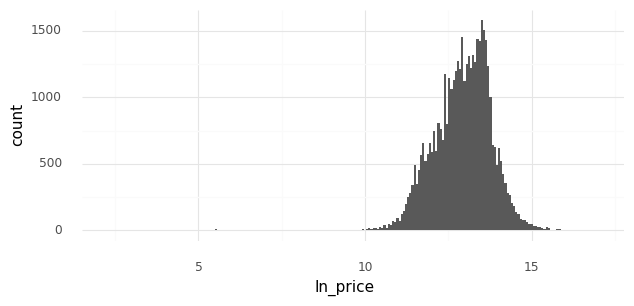

<ggplot: (8762590386363)>

In [12]:
(
    ggplot(pd.DataFrame(dict(ln_price=train_Y)),
           aes(x="ln_price")) +
    geom_histogram() +
    theme_minimal() +
    theme(figure_size = (7,3)) 
)

No red flags. Look at how our predictors relate to the outcome.

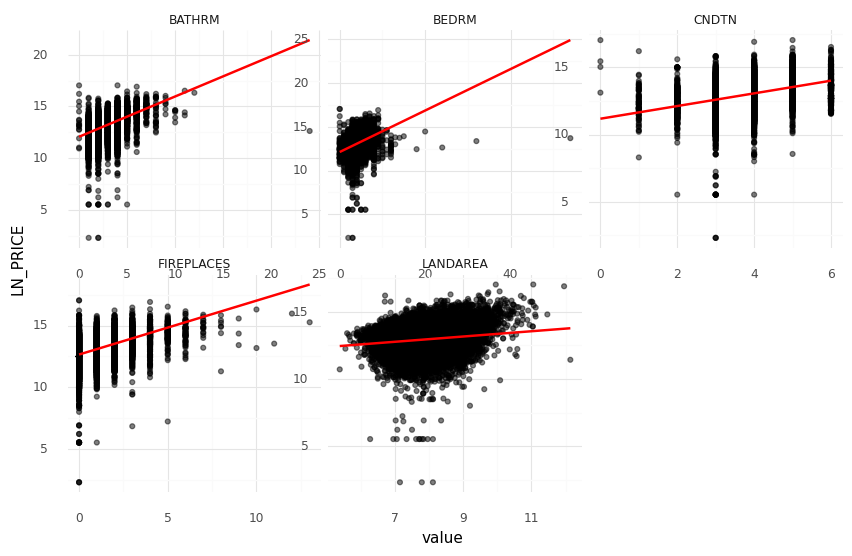

<ggplot: (8762592733181)>

In [13]:
D = train_X.copy()
D['LN_PRICE'] = train_Y

(
    ggplot(D.melt(id_vars=["LN_PRICE"]),
           aes(x="value",y="LN_PRICE"))+
    geom_point(alpha=.5) +
    geom_smooth(method="lm",se=False,color="red") +
    facet_wrap("variable",scales="free") +
    
    theme_minimal() +
    theme(figure_size = (10,6)) 
)

## Pre-Processing

Rescale training data (add to pipeline later)

In [14]:
#Scale the data 
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

In [15]:
# Convert back into data frame
train_X = pd.DataFrame(train_X,columns=col_names)
train_X

,BATHRM,BEDRM,CNDTN,FIREPLACES,LANDAREA
0,0.125000,0.074074,0.833333,0.000000,0.345337
1,0.083333,0.055556,0.833333,0.076923,0.425790
2,0.083333,0.074074,0.500000,0.076923,0.531400
3,0.041667,0.055556,0.500000,0.000000,0.375461
4,0.083333,0.074074,0.500000,0.000000,0.335982
...,...,...,...,...,...
43576,0.041667,0.037037,0.500000,0.076923,0.140818
43577,0.083333,0.055556,0.666667,0.076923,0.284773
43578,0.083333,0.074074,0.666667,0.153846,0.275519
43579,0.125000,0.055556,0.666667,0.076923,0.207292


# Modeling

Run the following models:

- Linear Regression 
- KNN
- Decision Trees
- Bagging 
- Random Forest


For each model, use **K-fold cross-validation** to estimate the test error. Use **5 folds** when cross-validating.

Use same data splits for each fold for all models.

In [16]:
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

Run each model individually (using defaults for any tuning parameters and then compare the performance of the different models in a plot.

Use **mean squared error** as performance metrics.

In [17]:
use_metrics = ["neg_mean_squared_error"]

## Run the Models

### Linear Model

In [18]:
lm_scores = cross_validate(LM(),train_X,train_Y, cv = fold_generator, scoring =use_metrics)

### KNN

In [19]:
knn_scores = cross_validate(KNN(),train_X,train_Y, cv = fold_generator, scoring =use_metrics)

### Decision Tree

In [20]:
dt_scores = cross_validate(DTree(),train_X,train_Y, cv = fold_generator, scoring =use_metrics)

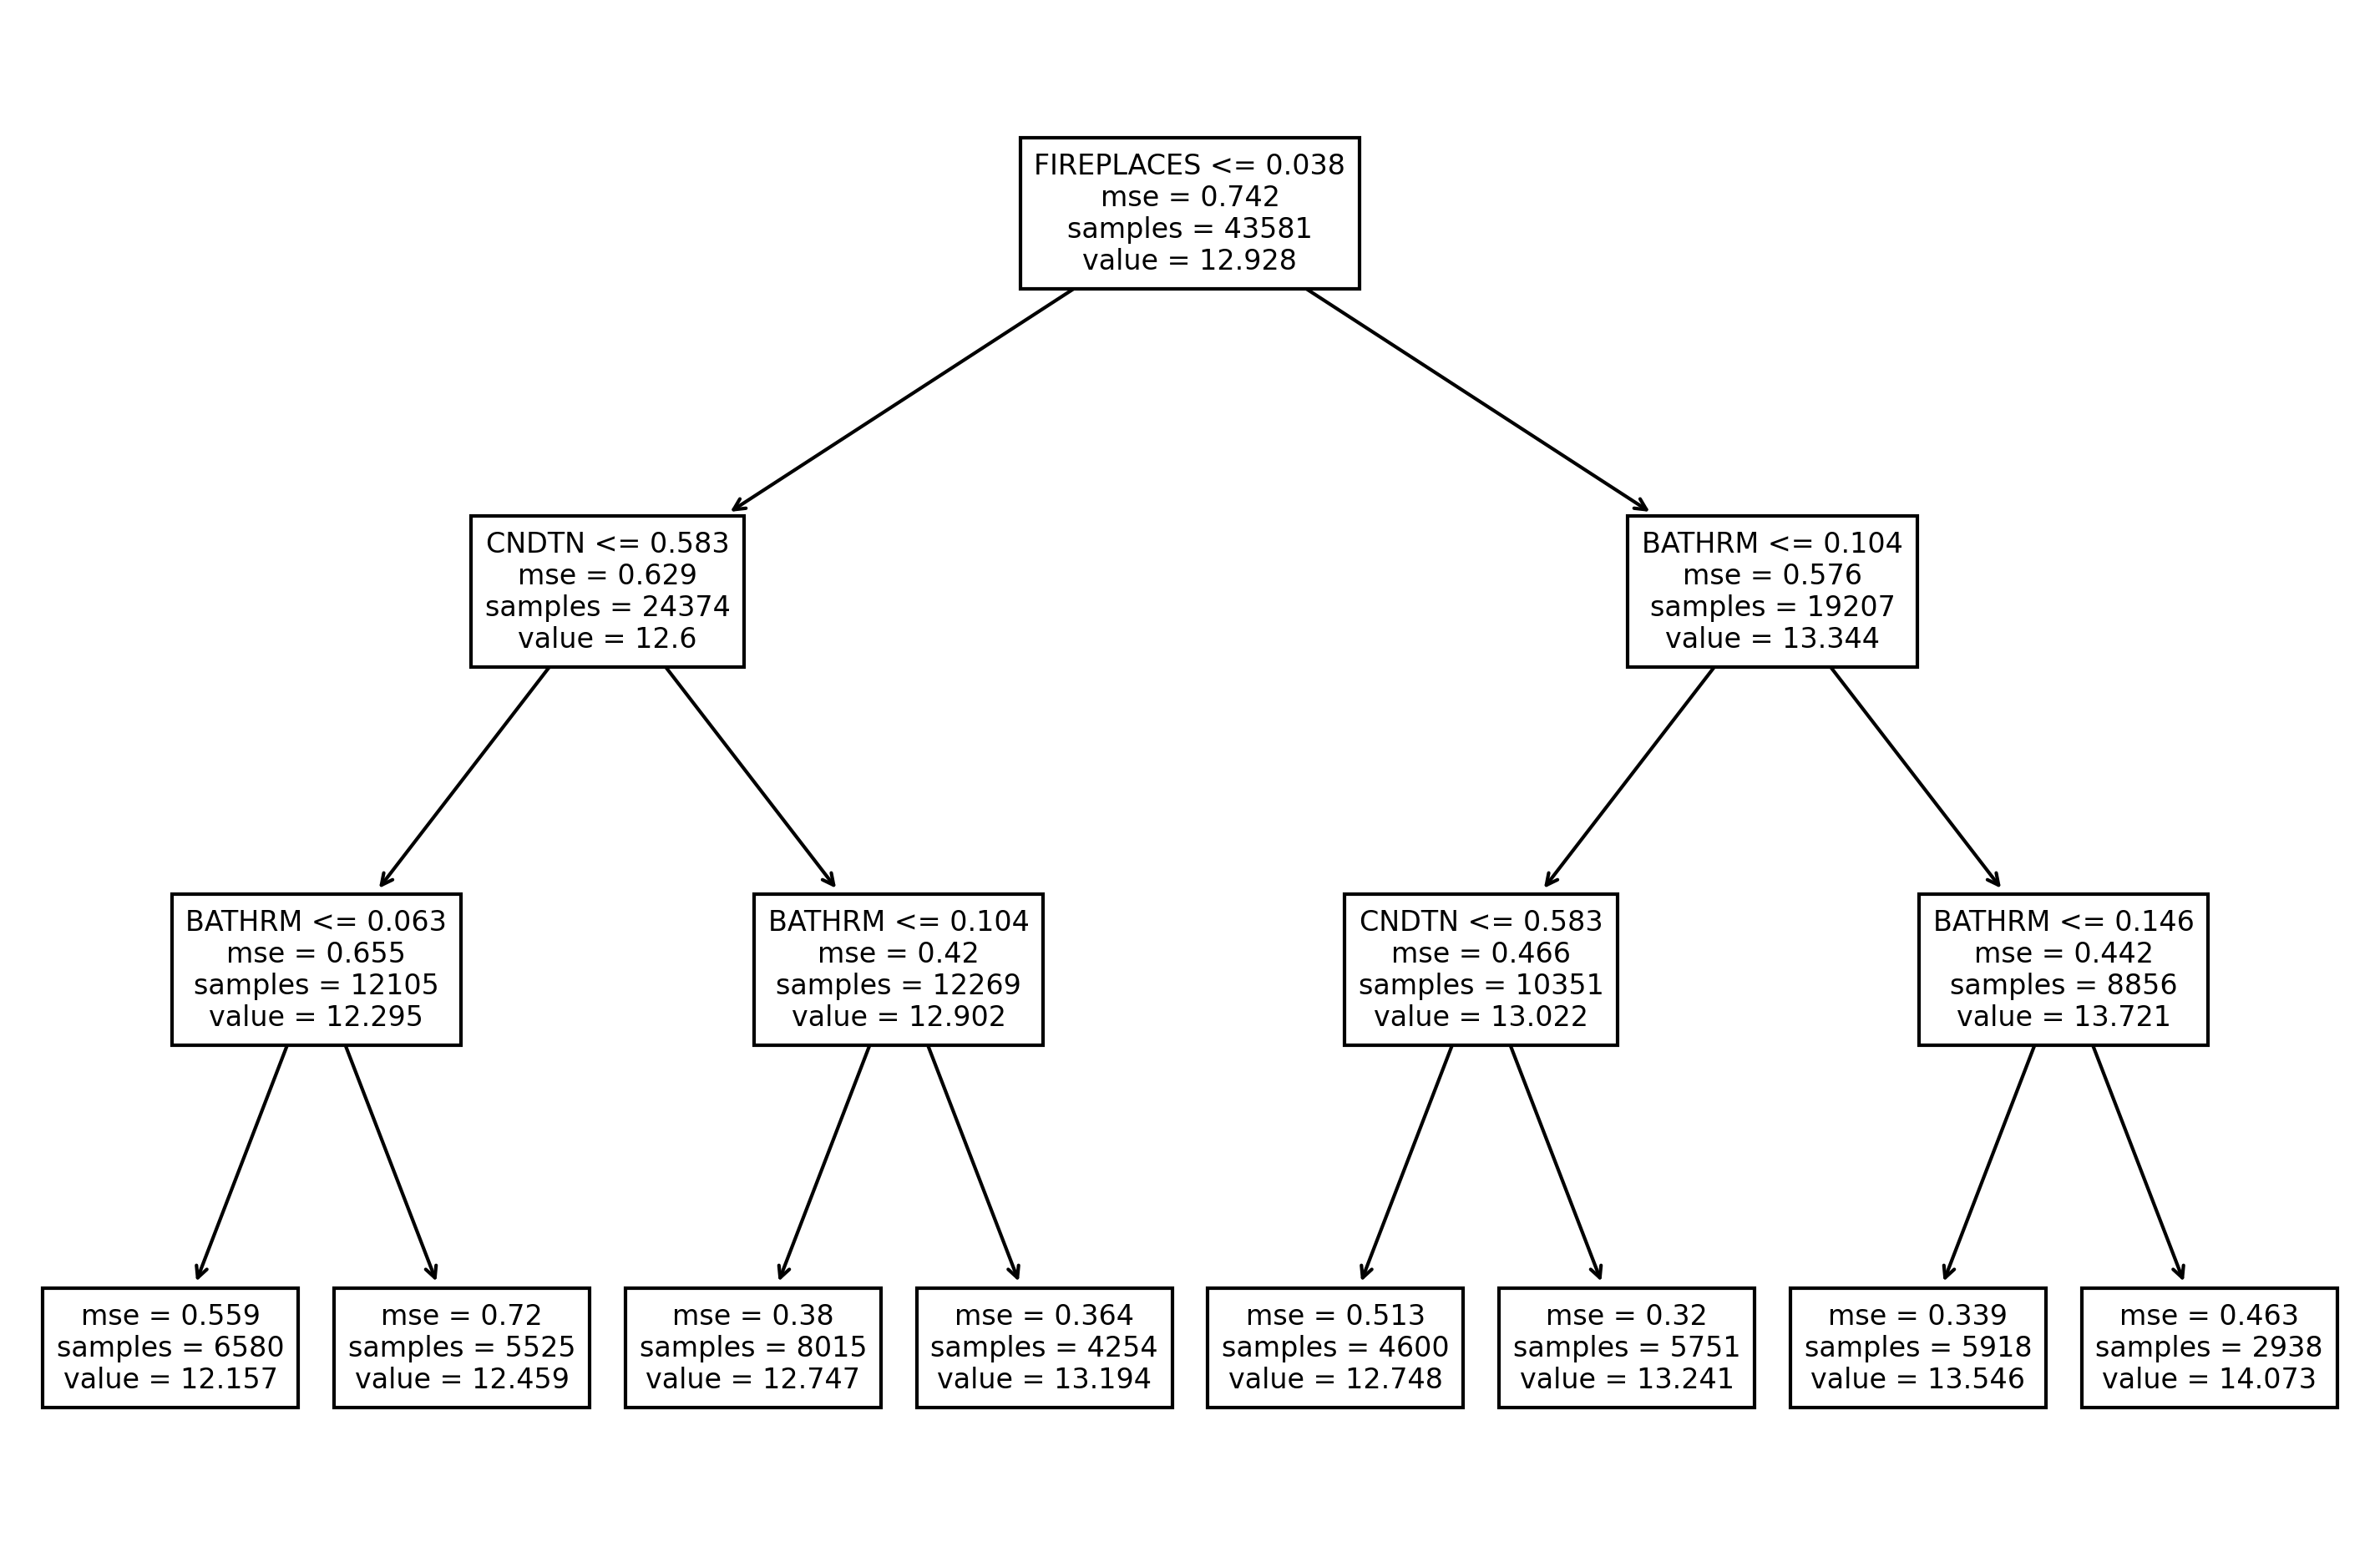

In [21]:
mod = DTree(max_depth=3) # Initialize the modeling object
mod.fit(train_X,train_Y) # Fit the mode

# Plot the tree
plt.figure(figsize=(12,8),dpi=300)
rules = tree.plot_tree(mod,feature_names = col_names,fontsize=8)

### Bagging

In [22]:
bag_scores = cross_validate(Bag(),train_X,train_Y, cv = fold_generator, scoring =use_metrics)

### Random Forest

In [23]:
rf_scores = cross_validate(RF(),train_X,train_Y, cv = fold_generator, scoring =use_metrics)

## Compare Models

In [24]:
# Output is a dictionary 
lm_scores

{'fit_time': array([0.00423503, 0.00366902, 0.00323272, 0.003227  , 0.00617099]),
 'score_time': array([0.00183392, 0.00114298, 0.00097632, 0.00099301, 0.00225925]),
 'test_neg_mean_squared_error': array([-0.46912163, -0.45188358, -0.43512243, -0.43317051, -0.4443808 ])}

We can collect the scores of the metrics we care about. 

In [25]:
# Collect all the metrics we care about as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,0.469122
1,lm,0.451884
2,lm,0.435122
3,lm,0.433171
4,lm,0.444381
5,knn,0.492190
6,knn,0.477412
7,knn,0.459388
8,knn,0.456709
9,knn,0.469199


And Plot

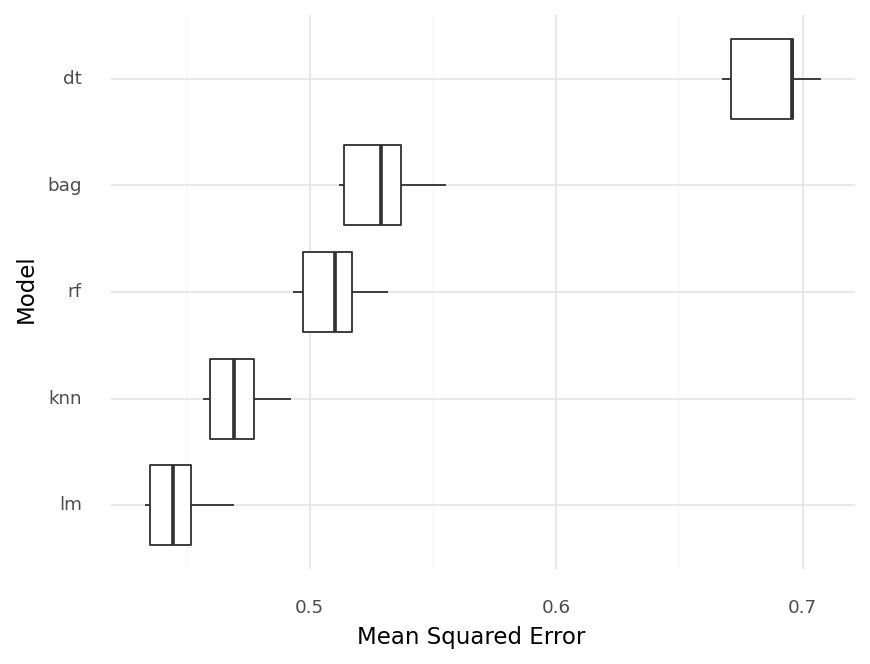

<ggplot: (8762607201530)>

In [26]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

Lower is better. The linear model appears to do the best here.  

# Tuning Hyper-parameters

Tweak relevant parameters to change our model's performance.

For K-Nearest Neighbors model, set `k` (or `n_neighbors` in `sklearn`) at different values which determines the degree to which we **overfit** or **underfit** the data.

In [27]:
set_k = dict()
for k in [1,5,10,50,100,250]:
    score = cross_validate(KNN(n_neighbors=k),
                           train_X,train_Y, 
                           cv = fold_generator, 
                           scoring =use_metrics)
    s = score['test_neg_mean_squared_error']
    set_k[k] = s.mean()
 
set_k

{1: -0.7565977915091197,
 5: -0.4709796661284136,
 10: -0.4352947786376837,
 50: -0.41136648372964474,
 100: -0.41182436699844116,
 250: -0.4169308164288455}

As we can see from the above example, when we set higher values of `k`, we get a better out of sample fit (`k = 1` being the worse), but after `k = 100`, we shift out of overfitting territory and into underfitting territory. So choosing the right value of `k` is crucial to making this method work.

Systematically tune parameters using `sklearn`'s `GridSearchCV`.**

## `GridSearchCV`

A Grid search performance an exhaustive search over specified parameter values for an estimator. That is, we specify all potential values our tuning parameter can take on and then we use cross-validation to compare the out-of-sample performance for different parameter configurations. The result is that we can identify the parameter that performs best.

To list off all the parameters for a model:

In [28]:
mod = KNN() # Initialize the model class
mod.get_params() # report all the available tunning parameters 

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Focus on `n_neighbors`.

For the grid search, pass it a dictionary of all the tuning parameter values that we want to explore.

In [29]:
knn_tune_params = {'n_neighbors':[1, 10, 25, 35, 50, 75, 100, 250]}

From there we wrap the model method in the `GridSearchCV()` class. 

In [30]:
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

We then `.fit()` the model as per usual

In [31]:
tune_knn.fit(train_X,train_Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=4,
             param_grid={'n_neighbors': [1, 10, 25, 35, 50, 75, 100, 250]},
             scoring='neg_mean_squared_error')

Once fit, the model reports back the best fitting parameters.

In [32]:
tune_knn.best_params_

{'n_neighbors': 75}

In [33]:
tune_knn.best_score_

-0.41103102882949305

## Model Tuning 

Tune our hyperparameters for the other models. (_Note_: For the linear model, there are no hyperparameters, and Bagging is an ensemble approach rather than it's own model, so we won't be tuned)

### Decision Tree

Get parameters. Choose to focus on `max_depth`. 

In [34]:
DTree().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [35]:
tune_dt = GridSearchCV(DTree(),{'max_depth':[i for i in range(10)]},
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [36]:
tune_dt.fit(train_X,train_Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=4,
             param_grid={'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='neg_mean_squared_error')

In [37]:
tune_dt.best_params_

{'max_depth': 7}

In [38]:
tune_dt.best_score_

-0.41515220819018933

### Random Forest

Focus on `max_depth` and `n_estimators` (i.e. the number of trees to grow and ensemble across) and `max_features` (i.e. the number of predictors to consider when growing each tree). 

In [39]:
RF().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [40]:
rf_params = {'max_depth':[1,2,3],
             'n_estimators':[100,500,1000],
              'max_features': [1,2,3,4]} # Only have five total. 
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [41]:
tune_rf.fit(train_X,train_Y) 

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [1, 2, 3], 'max_features': [1, 2, 3, 4],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error')

In [42]:
tune_rf.best_params_

{'max_depth': 3, 'max_features': 3, 'n_estimators': 500}

In [43]:
tune_rf.best_score_

-0.44011948916766175

# Modeling Pipeline

Piece together all these steps as one seamless pipeline.

In [44]:
#Start from the initial uncleaned datasets and apply pre-processing steps
#This is to avoid applying pre-processing steps twice

# OUTCOME: log selling price 
train_Y = train['LN_PRICE'] 
test_Y = test['LN_PRICE']

#Subset to predictor variables and log landarea
train_X = train[['BATHRM', 'BEDRM','CNDTN','FIREPLACES', 'LANDAREA']] 
train_X['LANDAREA'] = np.log(train_X['LANDAREA'])

test_X = test[['BATHRM', 'BEDRM','CNDTN','FIREPLACES', 'LANDAREA']] 
test_X['LANDAREA'] = np.log(test_X['LANDAREA'])


# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BATHRM', 'BEDRM', 'CNDTN','FIREPLACES', 'LANDAREA'])])

# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[1, 10, 25, 35, 50, 75, 100, 250]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,4,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3,4,5],
     'model__n_estimators':[500,1000,1500,2000,2500]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'BEDRM',
                                                                          'CNDTN',
                                                                          'FIREPLACES',
                                                                          'LANDAREA'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(n_neighbors=75)],
                          'model__n_neighbors': [1, 10, 25, 35, 50,

Let's look at the best fit score from the scan.

In [45]:
search.best_score_ # Mean out-of-sample (CV) error

-0.4105481236802473

Look at the best model

In [46]:
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=75), 'model__n_neighbors': 75}

# Test Performance

See how well the best performing model does on the test data that it wasn't trained on. 

In [47]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [48]:
m.mean_squared_error(test_Y,pred_y)

0.4096825167440198

In [49]:
m.r2_score(test_Y,pred_y)

0.445706693479759

Visualize

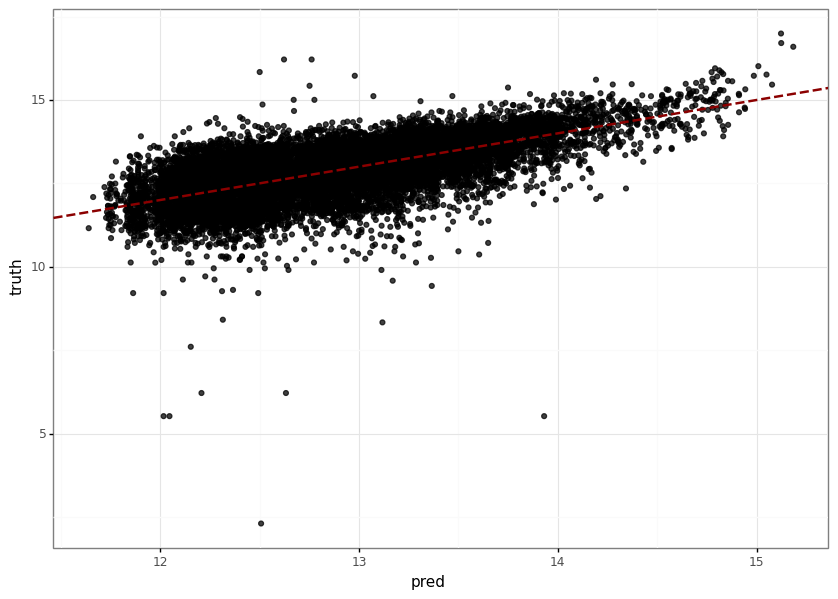

<ggplot: (8762521971354)>

In [50]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_Y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

The model that best fits our data is the KNN model that uses 75 neighbors in the training data when making a prediction for the test data. This model uses the number of bathrooms, bedrooms, and fireplaces, the condition of the house, and the land area as its predictors. This model has a mean squared error of 0.41 (lower than the example model in the lecture) and an R squared of 44.6 percent (higher than the example model in the lecture), which indicates that the model performs better than the example model in the lecture.